<a href="https://colab.research.google.com/github/mateuszrajca69/r/blob/main/08_12.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



# **A regression example**

Common type of machine learning problem is "regression", which consists of predicting a continuous value instead of a discrete label. For instance, predicting the temperature tomorrow, given meteorological data, or predicting the time that a software project will take to complete, given its specifications.



In [1]:

from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout
from keras import optimizers
from keras.callbacks import EarlyStopping

import numpy as np
import matplotlib.pyplot as plt



In [2]:
# install optuna
! pip install optuna

     |████████████████████████████████| 286kB 14.6MB/s 
     |████████████████████████████████| 81kB 10.6MB/s 
     |████████████████████████████████| 163kB 34.9MB/s 
     |████████████████████████████████| 112kB 40.0MB/s 
     |████████████████████████████████| 133kB 55.0MB/s 
     |████████████████████████████████| 51kB 8.2MB/s 
     |████████████████████████████████| 81kB 11.1MB/s 
  Created wheel for PrettyTable: filename=prettytable-0.7.2-cp36-none-any.whl size=13702 sha256=e3a604ed4b7de656fb0e662783b034c988774b4181581d505be6f04e6f3edc91
  Stored in directory: /root/.cache/pip/wheels/80/34/1c/3967380d9676d162cb59513bd9dc862d0584e045a162095606
  Created wheel for pyperclip: filename=pyperclip-1.8.1-cp36-none-any.whl size=11120 sha256=f8196fad55cd1cecbf01b97b0ba6221a783c6c6f502e5e53b91dffa38978d497
  Stored in directory: /root/.cache/pip/wheels/44/10/3a/c830e9bb3db2c93274ea1f213a41fabde0d8cf3794251fad0c
Successfully built PrettyTable pyperclip
  Found existing installation: prettyta

In [3]:
import optuna


**1-dimensional data**

In [4]:
def funct(x):
  return x*x*np.sin(x)+np.log(2*x)

size = 200
low=0
high=12
error=20

XX_train = np.random.uniform(low=low, high=high, size=size)
XX_test = np.random.uniform(low=low, high=high, size=size)
yy_train = funct(XX_train) + np.random.normal(0., error, size)
yy_test = funct(XX_test) + np.random.normal(0., error, size)

print(XX_train.shape, yy_train.shape)

(200,) (200,)


Plot the function and data

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: RuntimeWarning:

divide by zero encountered in log



<function matplotlib.pyplot.show>

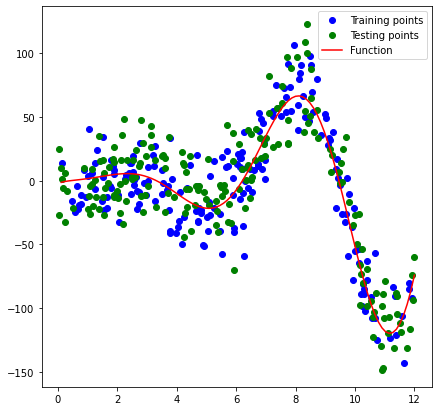

In [5]:
fig = plt.figure(figsize=(7,7))

plt.plot(XX_train,yy_train, 'o', color='blue', label='Training points')
plt.plot(XX_test,yy_test, 'o', color='green', label='Testing points')

points = np.linspace(low, high,num=100)
plt.plot(points, funct(points),  color='red', label='Function')
plt.legend()


plt.show


**Preparing the data**

It would be problematic to feed into a neural network values that all take wildly different ranges. The network might be able to automatically adapt to such heterogeneous data, but it would definitely make learning more difficult. A widespread best practice to deal with such data is to do feature-wise normalization: for each feature in the input data (a column in the input data matrix), we will subtract the mean of the feature and divide by the standard deviation, so that the feature will be centered around 0 and will have a unit standard deviation. This is easily done in Numpy:


In [6]:
# Tutaj należy znormalizować dane, i.e. 
# - odjąć średnią
# - podzielić przez odchylenie standardowe

# 
mean = XX_train.mean(axis=0)
XX_train_n = XX_train-mean
std = XX_train_n.std(axis=0)
XX_train_n /= std

# to samo dla x_test
XX_test_n = XX_test - mean
XX_test_n /= std

mean1 = yy_train.mean(axis=0)
yy_train_n = yy_train-mean1
std1 = yy_train_n.std(axis=0)
yy_train_n /= std1

# to samo dla y_test
yy_test_n = yy_test - mean1
yy_test_n /= std1

# A teraz to samo dla yy_train i yy_test
# dopisać to samo dla y

Define neural network

In [7]:
# Zbudować sieć neuronową, działa: dwie warstwy ukryte, aktywacja relu
from keras import models
from keras import layers



In [8]:

def objective(trial):
    units = trial.suggest_discrete_uniform('units', 8, 2048, 1)
    dropout = trial.suggest_uniform('dropout', 0, 0.5)
    lr = trial.suggest_float('lr',0.0005, 0.002, log=True)
    act= trial.suggest_categorical('activation',['relu','sigmoid','linear'])

    model0 = Sequential(name='network')
    #.....
    model0.add(layers.Dense(units, activation=act, input_shape=(1,)))
    model0.add(Dropout(dropout))
    model0.add(layers.Dense(units, activation=act))
    model0.add(Dropout(dropout))
    model0.add(layers.Dense(1, activation='linear'))
    # early stopping
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50 )
    
    #model0.summary()
    opt=optimizers.RMSprop(lr=lr)
    model0.compile(optimizer=opt,
                       loss='mean_squared_error',
                       metrics=['mse'])
    history = model0.fit(XX_train_n, yy_train_n,
                                     epochs=500,
                                     batch_size=128,
                                     validation_data=(XX_test_n, yy_test_n),
                                     verbose = 0, callbacks=[es])
    results = model0.evaluate(XX_test_n, yy_test_n)
    return results[0]

In [9]:
study = optuna.create_study()
study = optuna.create_study(direction='minimize', pruner=optuna.pruners.MedianPruner(), sampler=optuna.samplers.TPESampler() )

study.optimize(objective, n_trials=20)

study.best_params 


[I 2021-01-12 13:40:46,902] A new study created in memory with name: no-name-3fb37870-2656-4075-bd27-b0f4c1be1b48
[I 2021-01-12 13:40:46,905] A new study created in memory with name: no-name-20fe4557-acbe-4ce7-bfa7-ef45de2f6713


7/7 [==============================] - 0s 2ms/step - loss: 0.2511 - mse: 0.2511


[I 2021-01-12 13:41:18,818] Trial 0 finished with value: 0.2510663568973541 and parameters: {'units': 615.0, 'dropout': 0.3160960762302081, 'lr': 0.0018790229635157498, 'activation': 'sigmoid'}. Best is trial 0 with value: 0.2510663568973541.


Epoch 00056: early stopping
7/7 [==============================] - 0s 3ms/step - loss: 1.0398 - mse: 1.0398


[I 2021-01-12 13:41:22,495] Trial 1 finished with value: 1.0397861003875732 and parameters: {'units': 1675.0, 'dropout': 0.48349407081649015, 'lr': 0.0013339462370417629, 'activation': 'linear'}. Best is trial 0 with value: 0.2510663568973541.


7/7 [==============================] - 0s 2ms/step - loss: 1.0017 - mse: 1.0017


[I 2021-01-12 13:41:47,698] Trial 2 finished with value: 1.001672625541687 and parameters: {'units': 193.0, 'dropout': 0.3438381347823694, 'lr': 0.0005506875605001471, 'activation': 'sigmoid'}. Best is trial 0 with value: 0.2510663568973541.


Epoch 00103: early stopping
7/7 [==============================] - 0s 2ms/step - loss: 1.0452 - mse: 1.0452


[I 2021-01-12 13:41:53,476] Trial 3 finished with value: 1.0451911687850952 and parameters: {'units': 898.0, 'dropout': 0.22391239766064647, 'lr': 0.001973545642901449, 'activation': 'linear'}. Best is trial 0 with value: 0.2510663568973541.


Epoch 00086: early stopping
7/7 [==============================] - 0s 2ms/step - loss: 1.0963 - mse: 1.0963


[I 2021-01-12 13:41:58,299] Trial 4 finished with value: 1.0963172912597656 and parameters: {'units': 671.0, 'dropout': 0.447516689728083, 'lr': 0.0006889295119878782, 'activation': 'linear'}. Best is trial 0 with value: 0.2510663568973541.


Epoch 00060: early stopping
7/7 [==============================] - 0s 2ms/step - loss: 1.0505 - mse: 1.0505


[I 2021-01-12 13:42:02,079] Trial 5 finished with value: 1.050504207611084 and parameters: {'units': 725.0, 'dropout': 0.13441688718699873, 'lr': 0.0016525222590942073, 'activation': 'linear'}. Best is trial 0 with value: 0.2510663568973541.


7/7 [==============================] - 0s 2ms/step - loss: 0.9091 - mse: 0.9091


[I 2021-01-12 13:42:27,065] Trial 6 finished with value: 0.9091224074363708 and parameters: {'units': 1193.0, 'dropout': 0.2059470962210136, 'lr': 0.0005716822572366084, 'activation': 'sigmoid'}. Best is trial 0 with value: 0.2510663568973541.


7/7 [==============================] - 0s 2ms/step - loss: 0.2563 - mse: 0.2563


[I 2021-01-12 13:42:52,347] Trial 7 finished with value: 0.25625190138816833 and parameters: {'units': 811.0, 'dropout': 0.4704426375029676, 'lr': 0.0017442448163618688, 'activation': 'sigmoid'}. Best is trial 0 with value: 0.2510663568973541.


Epoch 00052: early stopping
7/7 [==============================] - 0s 2ms/step - loss: 1.0520 - mse: 1.0520


[I 2021-01-12 13:42:55,637] Trial 8 finished with value: 1.0519999265670776 and parameters: {'units': 187.0, 'dropout': 0.08766007035548723, 'lr': 0.0016139517497369903, 'activation': 'linear'}. Best is trial 0 with value: 0.2510663568973541.


Epoch 00103: early stopping
7/7 [==============================] - 0s 2ms/step - loss: 1.0417 - mse: 1.0417


[I 2021-01-12 13:43:01,329] Trial 9 finished with value: 1.0416675806045532 and parameters: {'units': 465.0, 'dropout': 0.23483382091934646, 'lr': 0.001598262207284451, 'activation': 'linear'}. Best is trial 0 with value: 0.2510663568973541.


Epoch 00398: early stopping
7/7 [==============================] - 0s 2ms/step - loss: 0.2417 - mse: 0.2417


[I 2021-01-12 13:43:22,035] Trial 10 finished with value: 0.24173472821712494 and parameters: {'units': 1357.0, 'dropout': 0.34925159127416033, 'lr': 0.0010122113255916138, 'activation': 'relu'}. Best is trial 10 with value: 0.24173472821712494.


Epoch 00264: early stopping
7/7 [==============================] - 0s 2ms/step - loss: 0.2503 - mse: 0.2503


[I 2021-01-12 13:43:35,710] Trial 11 finished with value: 0.25030460953712463 and parameters: {'units': 1383.0, 'dropout': 0.3446821351690198, 'lr': 0.0009466193122547715, 'activation': 'relu'}. Best is trial 10 with value: 0.24173472821712494.


Epoch 00131: early stopping
7/7 [==============================] - 0s 2ms/step - loss: 0.2709 - mse: 0.2709


[I 2021-01-12 13:43:43,186] Trial 12 finished with value: 0.27094748616218567 and parameters: {'units': 1425.0, 'dropout': 0.35624079082296267, 'lr': 0.0009497562129712514, 'activation': 'relu'}. Best is trial 10 with value: 0.24173472821712494.


Epoch 00185: early stopping
7/7 [==============================] - 0s 2ms/step - loss: 0.2700 - mse: 0.2700


[I 2021-01-12 13:43:53,391] Trial 13 finished with value: 0.2700391113758087 and parameters: {'units': 1972.0, 'dropout': 0.39646739532361264, 'lr': 0.0009456057398430867, 'activation': 'relu'}. Best is trial 10 with value: 0.24173472821712494.


Epoch 00154: early stopping
7/7 [==============================] - 0s 2ms/step - loss: 0.2829 - mse: 0.2829


[I 2021-01-12 13:44:01,958] Trial 14 finished with value: 0.2829163372516632 and parameters: {'units': 1325.0, 'dropout': 0.2876197735378507, 'lr': 0.001139409155693807, 'activation': 'relu'}. Best is trial 10 with value: 0.24173472821712494.


Epoch 00324: early stopping
7/7 [==============================] - 0s 2ms/step - loss: 0.2383 - mse: 0.2383


[I 2021-01-12 13:44:18,701] Trial 15 finished with value: 0.2382739633321762 and parameters: {'units': 1650.0, 'dropout': 0.4142381159639973, 'lr': 0.0007711408607290092, 'activation': 'relu'}. Best is trial 15 with value: 0.2382739633321762.


Epoch 00352: early stopping
7/7 [==============================] - 0s 2ms/step - loss: 0.2792 - mse: 0.2792


[I 2021-01-12 13:44:38,020] Trial 16 finished with value: 0.2792326509952545 and parameters: {'units': 2000.0, 'dropout': 0.40207167903195234, 'lr': 0.0007061098533647272, 'activation': 'relu'}. Best is trial 15 with value: 0.2382739633321762.


Epoch 00264: early stopping
7/7 [==============================] - 0s 2ms/step - loss: 0.2651 - mse: 0.2651


[I 2021-01-12 13:44:52,752] Trial 17 finished with value: 0.26514652371406555 and parameters: {'units': 1683.0, 'dropout': 0.00040441951481676175, 'lr': 0.0007904311069461751, 'activation': 'relu'}. Best is trial 15 with value: 0.2382739633321762.


Epoch 00221: early stopping
7/7 [==============================] - 0s 2ms/step - loss: 0.2484 - mse: 0.2484


[I 2021-01-12 13:45:05,044] Trial 18 finished with value: 0.2483595609664917 and parameters: {'units': 1694.0, 'dropout': 0.41209452524365575, 'lr': 0.0011616819325954149, 'activation': 'relu'}. Best is trial 15 with value: 0.2382739633321762.


Epoch 00184: early stopping
7/7 [==============================] - 0s 2ms/step - loss: 0.2543 - mse: 0.2543


[I 2021-01-12 13:45:14,792] Trial 19 finished with value: 0.25434401631355286 and parameters: {'units': 1128.0, 'dropout': 0.290105735495665, 'lr': 0.000833719287255664, 'activation': 'relu'}. Best is trial 15 with value: 0.2382739633321762.


{'activation': 'relu',
 'dropout': 0.4142381159639973,
 'lr': 0.0007711408607290092,
 'units': 1650.0}

## Visualizing the Optimization History

In [10]:
from optuna.visualization import plot_optimization_history

plot_optimization_history(study)

## Visualizing High-dimensional Parameter Relationships

In [11]:
from optuna.visualization import plot_parallel_coordinate

plot_parallel_coordinate(study, params=['units', 'dropout'])

## Visualizing Parameter Relationships

In [12]:
from optuna.visualization import plot_contour

plot_contour(study)

### Selecting Parameters to Visualize

In [13]:
plot_contour(study, params=['units', 'dropout'])

## Visualizing Individual Parameters

In [14]:
from optuna.visualization import plot_slice

plot_slice(study)

### Selecting Parameters to Visualize

In [15]:
plot_slice(study, params=['units', 'dropout'])

## Visualizing Parameter Importances

In [16]:
from optuna.visualization import plot_param_importances

plot_param_importances(study)

In [17]:
trial = study.best_trial
units = int(trial.params.get('units'))
dropout = (trial.params.get('dropout'))
print(units)
print(dropout)

1650
0.4142381159639973


In [18]:
model0 = Sequential(name='network')
    #.....
model0.add(layers.Dense(units, activation='relu', input_shape=(1,)))
model0.add(Dropout(dropout))
model0.add(layers.Dense(units, activation='relu'))
model0.add(Dropout(dropout))
model0.add(layers.Dense(1, activation='linear'))
# early stopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50 )
    
#model0.summary()
opt=optimizers.RMSprop(lr=0.001)
model0.compile(optimizer=opt,
                       loss='mean_squared_error',
                       metrics=['mse'])
history = model0.fit(XX_train_n, yy_train_n,
                                     epochs=500,
                                     batch_size=128,
                                     validation_data=(XX_test_n, yy_test_n),
                                     verbose = 0, callbacks=[es])
results = model0.evaluate(XX_test_n, yy_test_n)

Epoch 00285: early stopping
7/7 [==============================] - 0s 2ms/step - loss: 0.2494 - mse: 0.2494


Plot loss

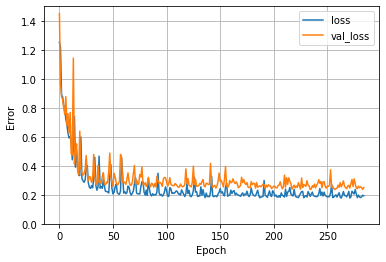

In [19]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim([0, 1.5])
  plt.xlabel('Epoch')
  plt.ylabel('Error ')
  plt.legend()
  plt.grid(True)

plot_loss(history)


Evaluate neural network

In [20]:
results = model0.evaluate(XX_test_n, yy_test_n)

print('loss test data: ', results[0])
print('mse test data: ', results[1])

results = model0.evaluate(XX_train_n, yy_train_n)

print('loss train data: ', results[0])
print('mse train data: ', results[1])

7/7 [==============================] - 0s 2ms/step - loss: 0.2494 - mse: 0.2494
loss test data:  0.24944964051246643
mse test data:  0.24944964051246643
7/7 [==============================] - 0s 2ms/step - loss: 0.1708 - mse: 0.1708
loss train data:  0.1707598865032196
mse train data:  0.1707598865032196


Plot results

<function matplotlib.pyplot.show>

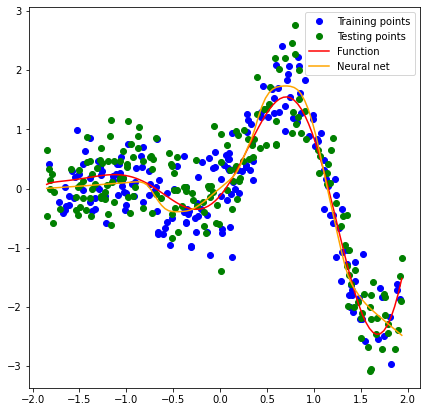

In [21]:
fig = plt.figure(figsize=(7,7))

plt.plot(XX_train_n,yy_train_n, 'o', color='blue', label='Training points')
plt.plot(XX_test_n,yy_test_n, 'o', color='green', label='Testing points')

points = np.linspace(min(XX_test_n), max(XX_test_n),num=100)
plt.plot(points, (funct(points*std+mean)-mean1)/std1,  color='red', label='Function')

plt.plot(points, model0.predict(points),  color='orange', label='Neural net')


plt.legend()


plt.show